# Deep Learning

Le but de ce projet est d'effectuer une classification sur le jeu de données MNIST en utilisant des réseaux de neurones. Pour cela, nous devons d'abord préparer les données en créant une base de validation à partir d'un tirage pseudo-aléatoire sur le jeu de données d'apprentissage. Ensuite, nous devons proposer des techniques de pré-traitement pour améliorer la qualité des données. Une fois les données préparées, notre objectif est de rechercher les combinaisons d'hyperparamètres qui permettront d'obtenir la meilleure performance de classification possible. Enfin, nous devons développer des fonctions pour visualiser les résultats de la classification pour tous les échantillons, ainsi que pour des échantillons spécifiques sélectionnés par l'utilisateur.



Pour réaliser ces objectifs, nous procéderons comme suit :
- Appliquer trois divers pré-traitements souhaités sur les données.
- Examiner les résultats obtenus pour chaque pré-traitement afin d'évaluer leur efficacité.
- Identifier les hyperparamètres appropriés qui permettront d'atteindre une classification optimale pour chaque pré-traitement en utilisant les données de validation.
- Comparer les performances des différents pré-traitements sur les données de test en utilisant un MLP, afin de déterminer lequel est le   plus efficace.
- Développer des fonctions de visualisation pour présenter de manière claire et concise les résultats de la classification, tout en            assurant la génération du fichier requirement.txt pour faciliter la reproduction du projet




### Setup

In [1]:
import pandas as pd
# Standard Arch
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import os
print("pandas V. ", pd.__version__)
print("tensorflow V. ", tf.__version__)

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

2024-04-12 12:51:05.600387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib is building the font cache; this may take a moment.


pandas V.  2.1.4
tensorflow V.  2.12.0


### Importation des données

In [3]:
import csv
path = "./"
csv_file = 'mnist_all.csv' 
mnist = pd.read_csv(path+csv_file, sep=',', index_col=False, header=None)

mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Divisons maintenant nos données en ``train`` et en ``test`` (resp 90% et 10%)

Pour avoir de simple manipulation pour la suite, mettons dans X les caracteristiques et dans y les labels

In [163]:
X = mnist.drop(0, axis = 1)
y = mnist[0]

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.1, random_state = 2, stratify=y)

### Representons les labels par l'encodage **one-hot**, pour cela nous allons utiliser la fonction `to_categorical` de `keras`

In [164]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
y_train.shape

(63000, 10)

 _______________________________________________________________________________________________________________________

Tout au long de ce projet, nous allons utiliser ces trois modèles pour chercher combien de neurone optimal nous devons utiliser.

Nous identifierons les hyperparamètres optimaux pour chaque modèle en menant des essais via GridSearchCV et en évaluant les performances de chacun sur notre ensemble de validation pour chaque pré-traitement. Nous explorerons les hyperparamètres suivants :
- Le nombre de couches cachées.
- Le nombre d'epochs.
- Le nombre de batches.
- Le type de kernel_initializer utilisé pour initialiser les poids de notre réseau de neurones.
- La fonction d'optimisation à utiliser pour l'entraînement de notre modèle.
- Le taux d'apprentissage utilisé pour optimiser la vitesse d'apprentissage de notre modèle.
- Le dropout optimal pour prévenir le surapprentissage.

In [117]:
#Modèle avec une seul couche cachée
def get_MLPmodel1(neurons):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

#Modèle avec une deux couche cachée
def get_MLPmodel2(neurons):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

#Modèle avec une trois couche cachée
def get_MLPmodel3(neurons):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(neurons,activation='relu'),
    tf.keras.layers.Dense(neurons,activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

Ci-dessous les declarations et les valeurs des hyperparametres à tester

**kernel_init**: nous avons sélectionnés trois méthodes d'initialiation du kernel d'une manière aléatoire parmi les méthodes existantes, les tester et garder la meilleure pour notre mmodèle tel que :
    -Zeros (Zéros) : Cette option initialise tous les poids avec des valeurs nulles.
    -Ones (Uns) : Cette option initialise tous les poids avec des valeurs égales à un.
    -Random Uniform: Cette option initialise les poids avec des valeurs aléatoires tirées à partir d'une distribution uniforme sur  l'intervalle [0, 1] Cela introduit de la variabilité initiale dans les poids.

**batch_size**:les tailles de batch sont séléctionnés de manière aléatoire parmi une gamme de valeurs typiquement utilisées dans la pratique. Cette approche nous permet d'explorer un large éventail de tailles de batch pour déterminer celle qui offre les meilleures performances en termes de vitesse de convergence et de stabilité de l'entraînement. En testant et en comparant ces différentes options, nous pourrons sélectionner la taille de batch optimale qui maximise les performances de notre modèle sur le jeu de données MNIST."
epochs :les nombres d'epochs sont sélectionner d'une manière aléatoire parmi une gamme de valeurs couramment utilisée pour exploiter leurs impact sur les performances du modèle pour déterminer la meilleure valeur d'épochs qui l'optimise.

**Fonction d'optimisation (optimizer) et taux d'apprentissage:**
il existe plusieurs fonctions d'optimisation pour un modele d'apprentissage dans notre analyse en va comparer les resultats de ces optimisateurs pour en garder le meilleur pour notre modèle.

- SGD consiste à effectuer une descente de gradient sur un échantillon aléatoire de données à chaque itération lieu d'utiliser toutes les données d'entraînement à chaque fois.
- RMSprop est un algorithme d'optimisation qui ajuste le taux d'apprentissage pour chaque poids du réseau neuronal en utilisant une moyenne mobile pondérée des carrés des gradients.
- Adam (Adaptive Moment Estimation) est une méthode d'optimisation qui s'adapte aux différents taux d'apprentissage pour chaque paramètre.stocke une estimation exponentielle des gradients passés et une estimation exponentielle des carrés des gradients passés
- Adagrad est un autre algorithme d'optimisation qui adapte le taux d'apprentissage pour chaque paramètre en fonction de sa fréquence d'apparition.

**Taux d'apprentissage(learning rate**): est un paramètre essentiel dans l'entrainement d'un modèle, il controle l'ampleur des ajustements des poids pendant l'optimisation pour trouver les valeurs optimales des poids.

Dans notre cas d'etude, nous allons tester plusieurs valeurs de learning rate avec différents optimiseurs afin de trouver la meilleure combinaison entre learning rate et d'optimiseur pour chaque prétraitement.

Le **dropout** est une méthode de régularisation employée dans les réseaux de neurones afin d'éviter le surapprentissage. Son principe repose sur la désactivation aléatoire d'un certain pourcentage de neurones pendant l'entraînement. Cette désactivation aléatoire favorise la réduction des liens entre les neurones, incitant ainsi le réseau à apprendre des caractéristiques plus robustes et plus généralisables. Dans cette section, nous allons examiner l'impact du dropout sur les performances de notre modèle.

In [59]:
# nombres de neurons à utiliser dans les couches cachées
neurons = [256, 128, 64]

# la taille batch 
batch_size = [200, 400, 800, 1200]

# nombre de passages complets du jeu de données d'entraînement à travers le modèle
epochs = [10, 30, 50]

# pour définir les poids initiaux des couches Keras, il y en a plusieurs initializer mais nous avons choisis ces trois:
# Zeros: des zeros
# ones: des 1
# random_uniform : des valeurs randoms
kernel_init = ['Zeros', 'ones', 'random_uniform']

# fonction d'optimisation
# SGD: gradient descent
optimizer = ['SGD', 'RMSprop', 'adam','Adagrad']

# learing rate
learning_rate = [0.1, 0.01, 0.001, 0.0001]

# taux de neurones à supprimer pendant l'entrainement
dropout_rate = [0.0, 0.2, 0.4]

In [139]:
# fonction pour comparer deux valeurs
def plot_progress(hist_name, name, valid, size):
    fig2, ax2 = plt.subplots(figsize = size)
    loss_curve = hist_name.history[name]
    plt.plot(loss_curve)
    if (valid == 1):
        val_loss_curve = hist_name.history['val_'+name]    
        plt.plot(val_loss_curve)
    plt.title(name)
    plt.show() 
    return

## Pré-traitements
À ce stade, nous importerons notre jeu de données et entreprendrons trois types de prétraitement distincts sur notre ensemble de données.
    -Le premier Prétraitement implique la normalisation des données en convertissant nos niveaux de gris en valeurs comprises entre 0 et 1.
    -Le deuxième Prétraitement implique l'établissement d'un seuil pour nos valeurs de pixel, les transformant en valeurs binaires, soit 0 ou 1.
    -Le toisième Prétraitement applique la SVD sur MNIST, on peut donc réduire la dimensionnalité de chaque image tout en conservant les caractéristiques les plus ignificatives la reconnaissance de chiffres

# 1- Cherchons les hyperparametres en normalisant les données avant les traitements

In [13]:
# Normalisation des données
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

In [14]:
# Prise des données de validation(10%) dans `X_train_norm`
X_train_norm, X_val_norm, y_train_norm, y_val_norm = train_test_split(X_train_norm ,y_train, test_size = 0.1, random_state = 2, stratify=y_train)

### Determinons le nombre de neurone optimal
Testons avec nos trois modèles et prenons le nombre de neurons avec lequel nous avons la maximum de performance avec les données de validation

In [35]:
model = KerasClassifier(model=get_MLPmodel1, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

Score: 0.951940 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9576190476190476


In [36]:
model = KerasClassifier(model=get_MLPmodel2, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

Score: 0.960300 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9676190476190476


In [37]:
model = KerasClassifier(model=get_MLPmodel3, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

Score: 0.946825 avec {'model__neurons': 128}
Performance sur l'ensemble de validation :  0.9541269841269842


D'après ces resultats, nous allons utiliser la modèle avec deux couches cachées et `256` comme nombre de neurones

In [42]:
def get_MLP_norm():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

## Determinons l' `epochs` et `batch_size`

In [43]:
model = KerasClassifier(model=get_MLP_norm, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:02:37.034489: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:02:37.074330: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:02:37.078762: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:02:37.110983: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:02:37.117254: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads fo

Score: 0.980282 avec {'batch_size': 200, 'epochs': 50}
Performance sur l'ensemble de validation :  0.9826984126984127


D'après ce resultat, nous avons trouvé notre batch_size qui est 200 et epochs qui est 50 pour notre modele

### Determinons le type de kernel_initializer

In [44]:
def get_MLP_norm(init):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer=init, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [50]:
model = KerasClassifier(model=get_MLP_norm, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__init=kernel_init)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:18:22.922325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:18:22.922378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:18:22.922485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.980511 avec {'model__init': 'random_uniform'}
Performance sur l'ensemble de validation :  0.981904761904762


Notre initializer est **random_uniform**

In [54]:
def get_MLP_norm(optimizer):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Determinons la fonction d'optimisation et le learning rate

In [55]:
model = KerasClassifier(model=get_MLP_norm, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__optimizer=optimizer,optimizer__learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:25:14.809451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:25:14.809451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:25:14.812110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.980617 avec {'model__optimizer': 'RMSprop', 'optimizer__learning_rate': 0.0001}
Performance sur l'ensemble de validation :  0.9814285714285714


Donc notre optimizer c'est **RMSprop** et notre learning_rate est **0.0001**

In [61]:
def get_MLP_norm(drop):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Determinons le "Dropout" régularisation

In [62]:
model = KerasClassifier(model=get_MLP_norm, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__drop=dropout_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_norm, y_train_norm)
val_score = grid.score(X_val_norm, y_val_norm)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:37:09.594265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:37:09.594265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:37:09.594264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.976085 avec {'model__drop': 0.2}
Performance sur l'ensemble de validation :  0.9798412698412698


Ainsi, nous allons supprimer 20% de neurones au cours de l'entrainement

In [64]:
def get_MLP_norm():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Evaluons maintenant le modele final en utilisant les hyperparametres observés ci-dessus

In [65]:
model= get_MLP_norm()
h= model.fit(X_train_norm, y_train_norm,
             validation_data=(X_val_norm,y_val_norm), 
             epochs=30, batch_size = 200, verbose=0)

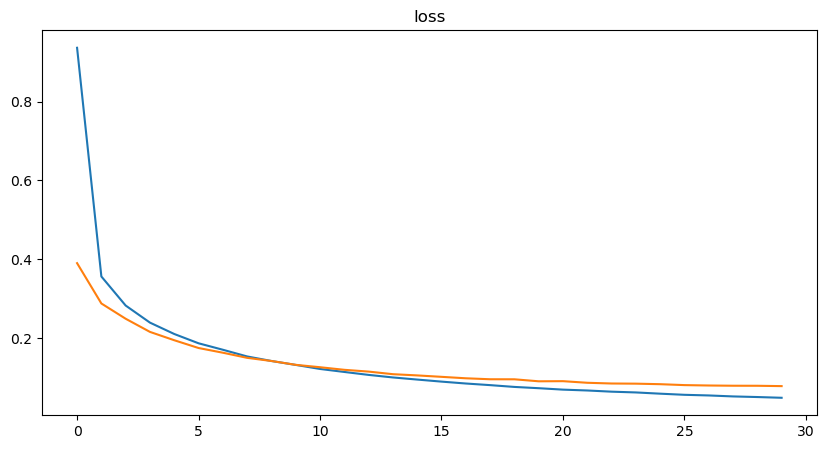

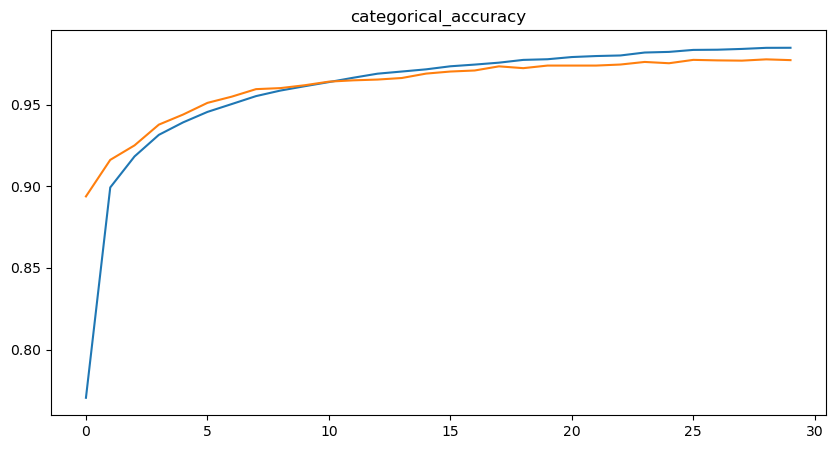

In [66]:
plot_progress(h, 'loss', 1, [10,5])
plot_progress(h, 'categorical_accuracy', 1, [10,5])

In [68]:
loss, accuracy = model.evaluate(X_test_norm, y_test)
print("Performance avec les donnees test ", accuracy)

219/219 [==============================] - 0s 675us/step - loss: 0.0690 - categorical_accuracy: 0.9773
Performance avec les donnees test  0.9772857427597046


# 2- Cherchons les hyperparametres en utilisant la seuillage des données avant les traitements

In [104]:
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

X_train_bin = np.where(X_train_norm > 0.5, 1, 0)
X_test_bin = np.where(X_test_norm > 0.5, 1, 0)

In [105]:
# Prise des données de validation(10%) dans `X_train_bin`
X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X_train_bin, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

### Nombre de neurone optimale

In [71]:
model = KerasClassifier(model=get_MLPmodel1, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:50:13.890024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:50:13.890021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:50:13.890017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.949735 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9555555555555556


In [75]:
model = KerasClassifier(model=get_MLPmodel2, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:53:56.170191: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:53:56.171538: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:53:56.178652: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:53:56.187232: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:53:56.187380: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads fo

Score: 0.955168 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9603174603174603


In [76]:
model = KerasClassifier(model=get_MLPmodel3, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:54:20.348054: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 14:54:20.353042: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.


Score: 0.950247 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9450793650793651


D'après ces resultats, nous allons utiliser le modèle avec deux couches cachées et `256` comme nombre de neurones

In [77]:
def get_MLP_bin():
  dimension = X.shape[1]
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Nombre d'epochs et de batch

In [78]:
model = KerasClassifier(model=get_MLP_bin, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 14:59:24.486253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:59:24.493099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:59:24.497340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.975362 avec {'batch_size': 200, 'epochs': 30}
Performance sur l'ensemble de validation :  0.9776190476190476


Donc pour la suite, notre epochs est **30** et batch_size est **200**

### Type d'initializer

In [84]:
def get_MLP_bin(init):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],) , kernel_initializer=init, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [85]:
model = KerasClassifier(model=get_MLP_bin, epochs=30, batch_size=200, verbose=0)
param_grid = dict(model__init=kernel_init)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 15:06:28.969439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:06:28.969439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:06:34.477421: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 15:06:34.531831: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with defaul

Score: 0.975714 avec {'model__init': 'random_uniform'}
Performance sur l'ensemble de validation :  0.9793650793650793


Initializer: **random_uniform**

### Fonction d'optimisation et learning_rate

In [87]:
def get_MLP_bin(optimizer):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],) , kernel_initializer="random_uniform", activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [88]:
model = KerasClassifier(model=get_MLP_bin, epochs=30, batch_size=200, verbose=0)
param_grid = dict(model__optimizer=optimizer,optimizer__learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 15:09:10.505780: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 15:09:10.519297: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 15:09:10.538094: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 15:09:10.570770: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
/home/11/ofandrianand/miniconda3/envs/deep_learning/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given

Score: 0.976102 avec {'model__optimizer': 'RMSprop', 'optimizer__learning_rate': 0.001}
Performance sur l'ensemble de validation :  0.9788888888888889


Optimizer: **RMSprop**
Learning_rate: **0.001**

### Dropout regularization

In [95]:
def get_MLP_bin(drop):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [96]:
model = KerasClassifier(model=get_MLP_bin, epochs=30, batch_size=200, verbose=0)
param_grid = dict(model__drop=drop)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_bin, y_train_bin)
val_score = grid.score(X_val_bin, y_val_bin)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 15:17:42.875299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:17:42.876777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:17:48.340688: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.
2024-04-12 15:17:48.346130: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with defaul

Score: 0.975891 avec {'model__drop': 0.2}
Performance sur l'ensemble de validation :  0.9784126984126984


Dropout: **20%**

### Evaluons maintenant le modele final en utilisant les hyperparametres observés ci-dessus

In [97]:
def get_MLP_bin():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [98]:
model= get_MLP_bin()
h= model.fit(X_train_bin, y_train_bin,
             validation_data=(X_val_bin,y_val_bin), 
             epochs=30, batch_size = 200, verbose= 0)


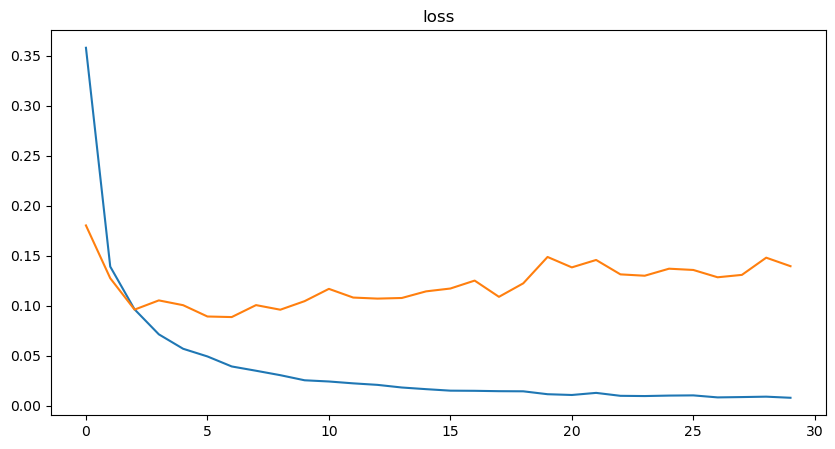

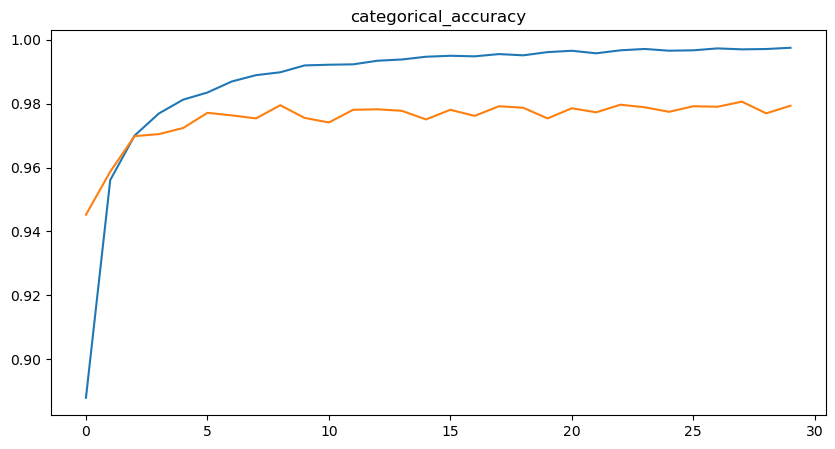

In [100]:
plot_progress(h, 'loss', 1, [10,5])
plot_progress(h, 'categorical_accuracy', 1, [10,5])

In [102]:
loss, accuracy = model.evaluate(X_test_norm, y_test)
print("Performance avec les donnees test ", accuracy)

219/219 [==============================] - 0s 924us/step - loss: 0.1049 - categorical_accuracy: 0.9821
Performance avec les donnees test  0.9821428656578064


# 3- Cherchons les hyperparametres en utilisant la SVD
Nous allons chercher les hyperparametres comme ce que nous avons fait precedemment. Mais avant cela nous allons appliquer la SVD sur ``train`` et ``test``.

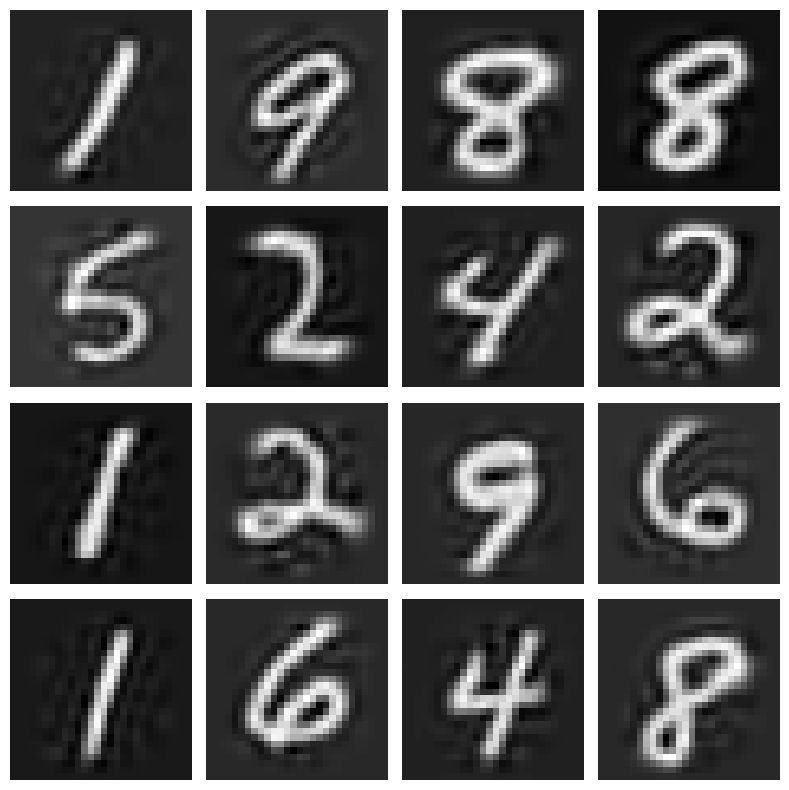

In [216]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100) # conserver 100 composantes principales
X_reduced = svd.fit_transform(X_train)
X_train_svd= svd.inverse_transform(X_reduced)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(16):
    ax = axes.flatten()[i]
    ax.imshow(X_train_svd[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

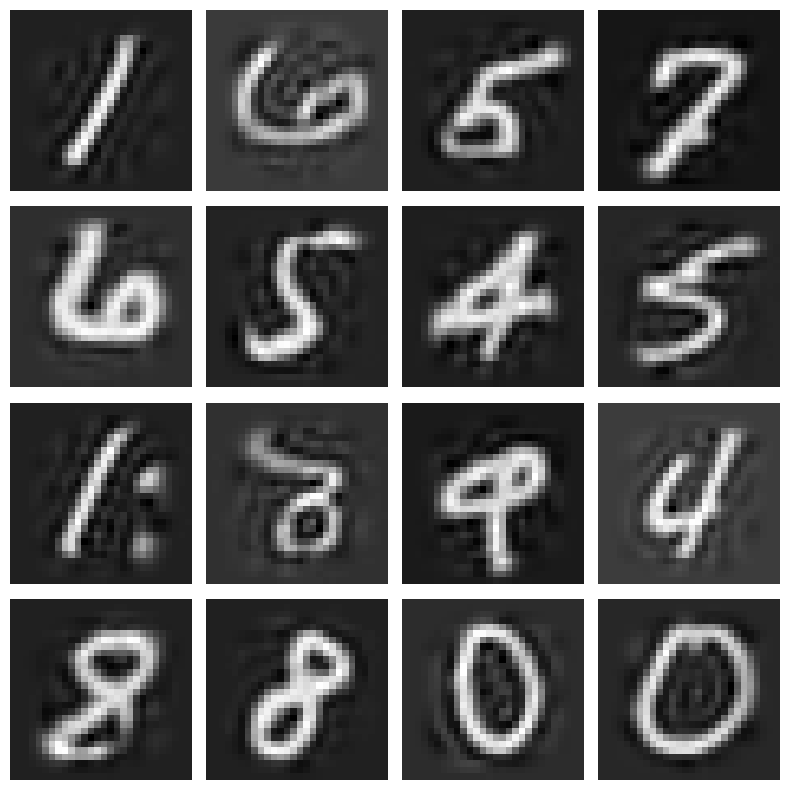

In [217]:
#appliquer svd sur les données de test
# Afficher les 16 premières images reconstruites
svd = TruncatedSVD(n_components=100) # conserver 100 composantes principales
X_reduced_train = svd.fit_transform(X_test)
X_test_svd= svd.inverse_transform(X_reduced_train)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(16):
    ax = axes.flatten()[i]
    ax.imshow(X_test_svd[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

Normalisons les données apres avoir appliqué la SVD

In [218]:
X_train_svd = X_train_svd/255.0
X_test_svd = X_test_svd/255.0

In [219]:
#génération du jeu de données de validation par une répartition équitable suivant les valeurs de y_train.
X_train_svd, X_val_svd, y_train_svd, y_val_svd = train_test_split(X_train_svd, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

### Nombre de neurone 

In [220]:
model = KerasClassifier(model=get_MLPmodel1, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 17:48:59.154516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:48:59.154516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:48:59.154516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.952116 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9625396825396826


In [227]:
model = KerasClassifier(model=get_MLPmodel2, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 17:52:36.049353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:52:41.734451: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 20. Tune using inter_op_parallelism_threads for best performance.


Score: 0.959559 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9684126984126984


In [228]:
model = KerasClassifier(model=get_MLPmodel3, verbose=0)
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 17:52:55.438763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:52:55.457464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:52:55.458369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.954515 avec {'model__neurons': 256}
Performance sur l'ensemble de validation :  0.9634920634920635


La meilleure architecture de réseau de neurones pour le prétraitement de svd est : 
`deux couches cachées avec 256 neurones chacune.`

In [229]:
def get_MLP_SVD():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Nombre d'epochs et de batch

In [230]:
model = KerasClassifier(model=get_MLP_SVD, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 17:53:29.391316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:53:29.446962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:53:29.451203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.981958 avec {'batch_size': 200, 'epochs': 50}
Performance sur l'ensemble de validation :  0.9826984126984127


Tous les modèles ont convergé après un nombre d'epochs de 50 et un batch_size de 200.

### Type de kernel_initializer

In [231]:
def get_MLP_svd(init):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer=init, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [232]:
model = KerasClassifier(model=get_MLP_svd, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__init=kernel_init)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

Score: 0.981728 avec {'model__init': 'random_uniform'}
Performance sur l'ensemble de validation :  0.9828571428571429


La méthode `random_uniform` est la plus adaptée

In [233]:
def get_MLP_svd(optimizer):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Fonction d'optimisation et learning_rate

In [234]:
model = KerasClassifier(model=get_MLP_svd, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__optimizer=optimizer, optimizer__learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

2024-04-12 17:58:42.536093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:58:42.536934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:58:42.667866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate

Score: 0.982187 avec {'model__optimizer': 'RMSprop', 'optimizer__learning_rate': 0.0001}
Performance sur l'ensemble de validation :  0.9839682539682539


Après avoir effectué la recherche de la meilleure combinaison de l'optimiseur et du taux d'apprentissage,c'est la fonction `RMSprop` avec un taux d'apprentissage de `0.0001` qui est la plus adaptée.

### Dropout régularisation

In [235]:
def get_MLP_svd(drop):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(drop),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model


In [236]:
model = KerasClassifier(model=get_MLP_svd, epochs=50, batch_size=200, verbose=0)
param_grid = dict(model__drop=drop)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_svd, y_train_svd)
val_score = grid.score(X_val_svd, y_val_svd)

print("Score: %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
print("Performance sur l'ensemble de validation : ", val_score)

Score: 0.978254 avec {'model__drop': 0.2}
Performance sur l'ensemble de validation :  0.9811111111111112


Dropout: **20%**

In [238]:
def get_MLP_svd():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

### Evaluons maintenant le modele final en utilisant les hyperparametres observés ci-dessus

In [239]:
model = get_MLP_svd()
h= model.fit(X_train_svd, y_train_svd,
             validation_data=(X_val_svd,y_val_svd), 
             epochs=50, batch_size = 200, verbose=0)

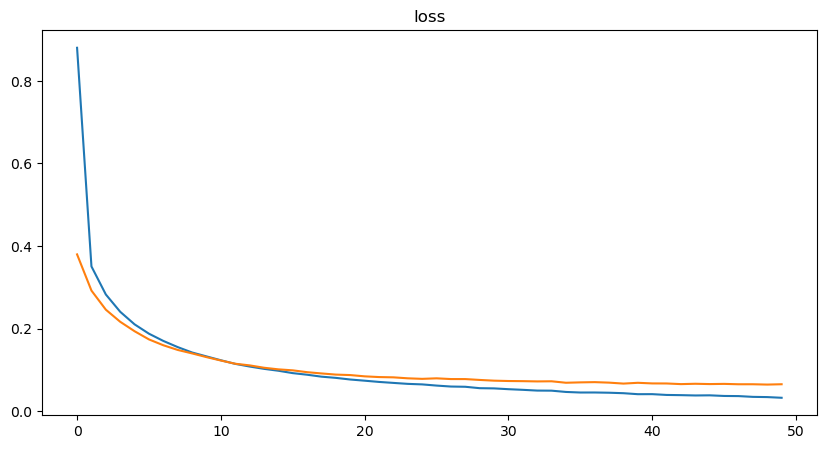

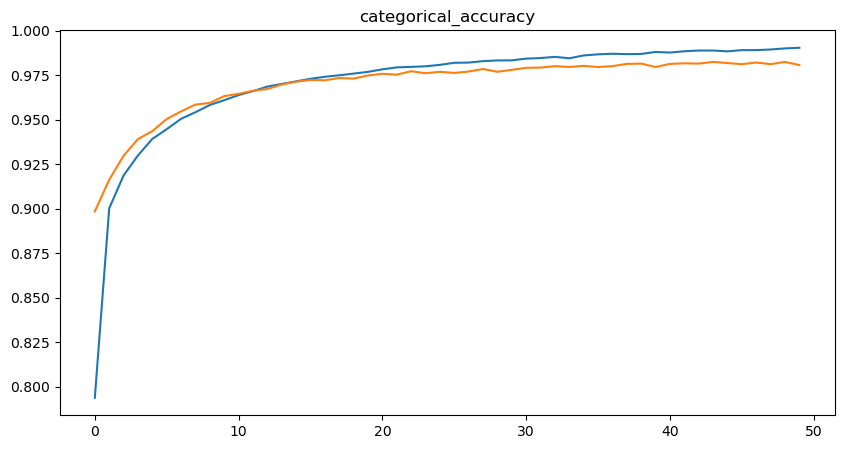

In [240]:
plot_progress(h, 'loss', 1, [10,5])
plot_progress(h, 'categorical_accuracy', 1, [10,5])

In [241]:
loss, accuracy = model.evaluate(X_test_svd, y_test)
print("Test accuracy for normalization preprocessing: ", accuracy)

219/219 [==============================] - 0s 786us/step - loss: 0.0600 - categorical_accuracy: 0.9824
Test accuracy for normalization preprocessing:  0.9824285507202148


Après avoir examiné toutes les spécifications et analysé les hyperparamètres, nous pouvons conclure que le modèle le mieux adapté à notre étude sur MNIST est celui qui intègre le prétraitement svd. Ce modèle se distingue par :
- Couche d'entrée : `256 neurones`
- kernel initializer : `random_uniform`
- 1ère couche cachée : `256 neurones`, fonction d'activation `ReLU`, dropout de `20%`
- 2ème couche cachée : `256 neurones`, fonction d'activation `ReLU`
- Couche de sortie : `10 neurones`, fonction d'activation `softmax`
- Fonction d'optimisation : `RMSprop`
- Learning rate : `0.0001`
- Nombre d'epochs : `50`
- Batch size : `200`

Ce modèle a donné de bons résultats avec une précision de test de 98,24% 

## Analyse des resultats obtenus

In [242]:
#convertion en format image 
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

#retour au format de classe
y_train= np.argmax(y_train, axis=1)
y_test= np.argmax(y_test, axis=1)

#prediction
y_pred = model.predict(X_test_svd)
# retour au format de classe
y_pred_c = np.argmax(y_pred, axis=1)

219/219 [==============================] - 0s 832us/step


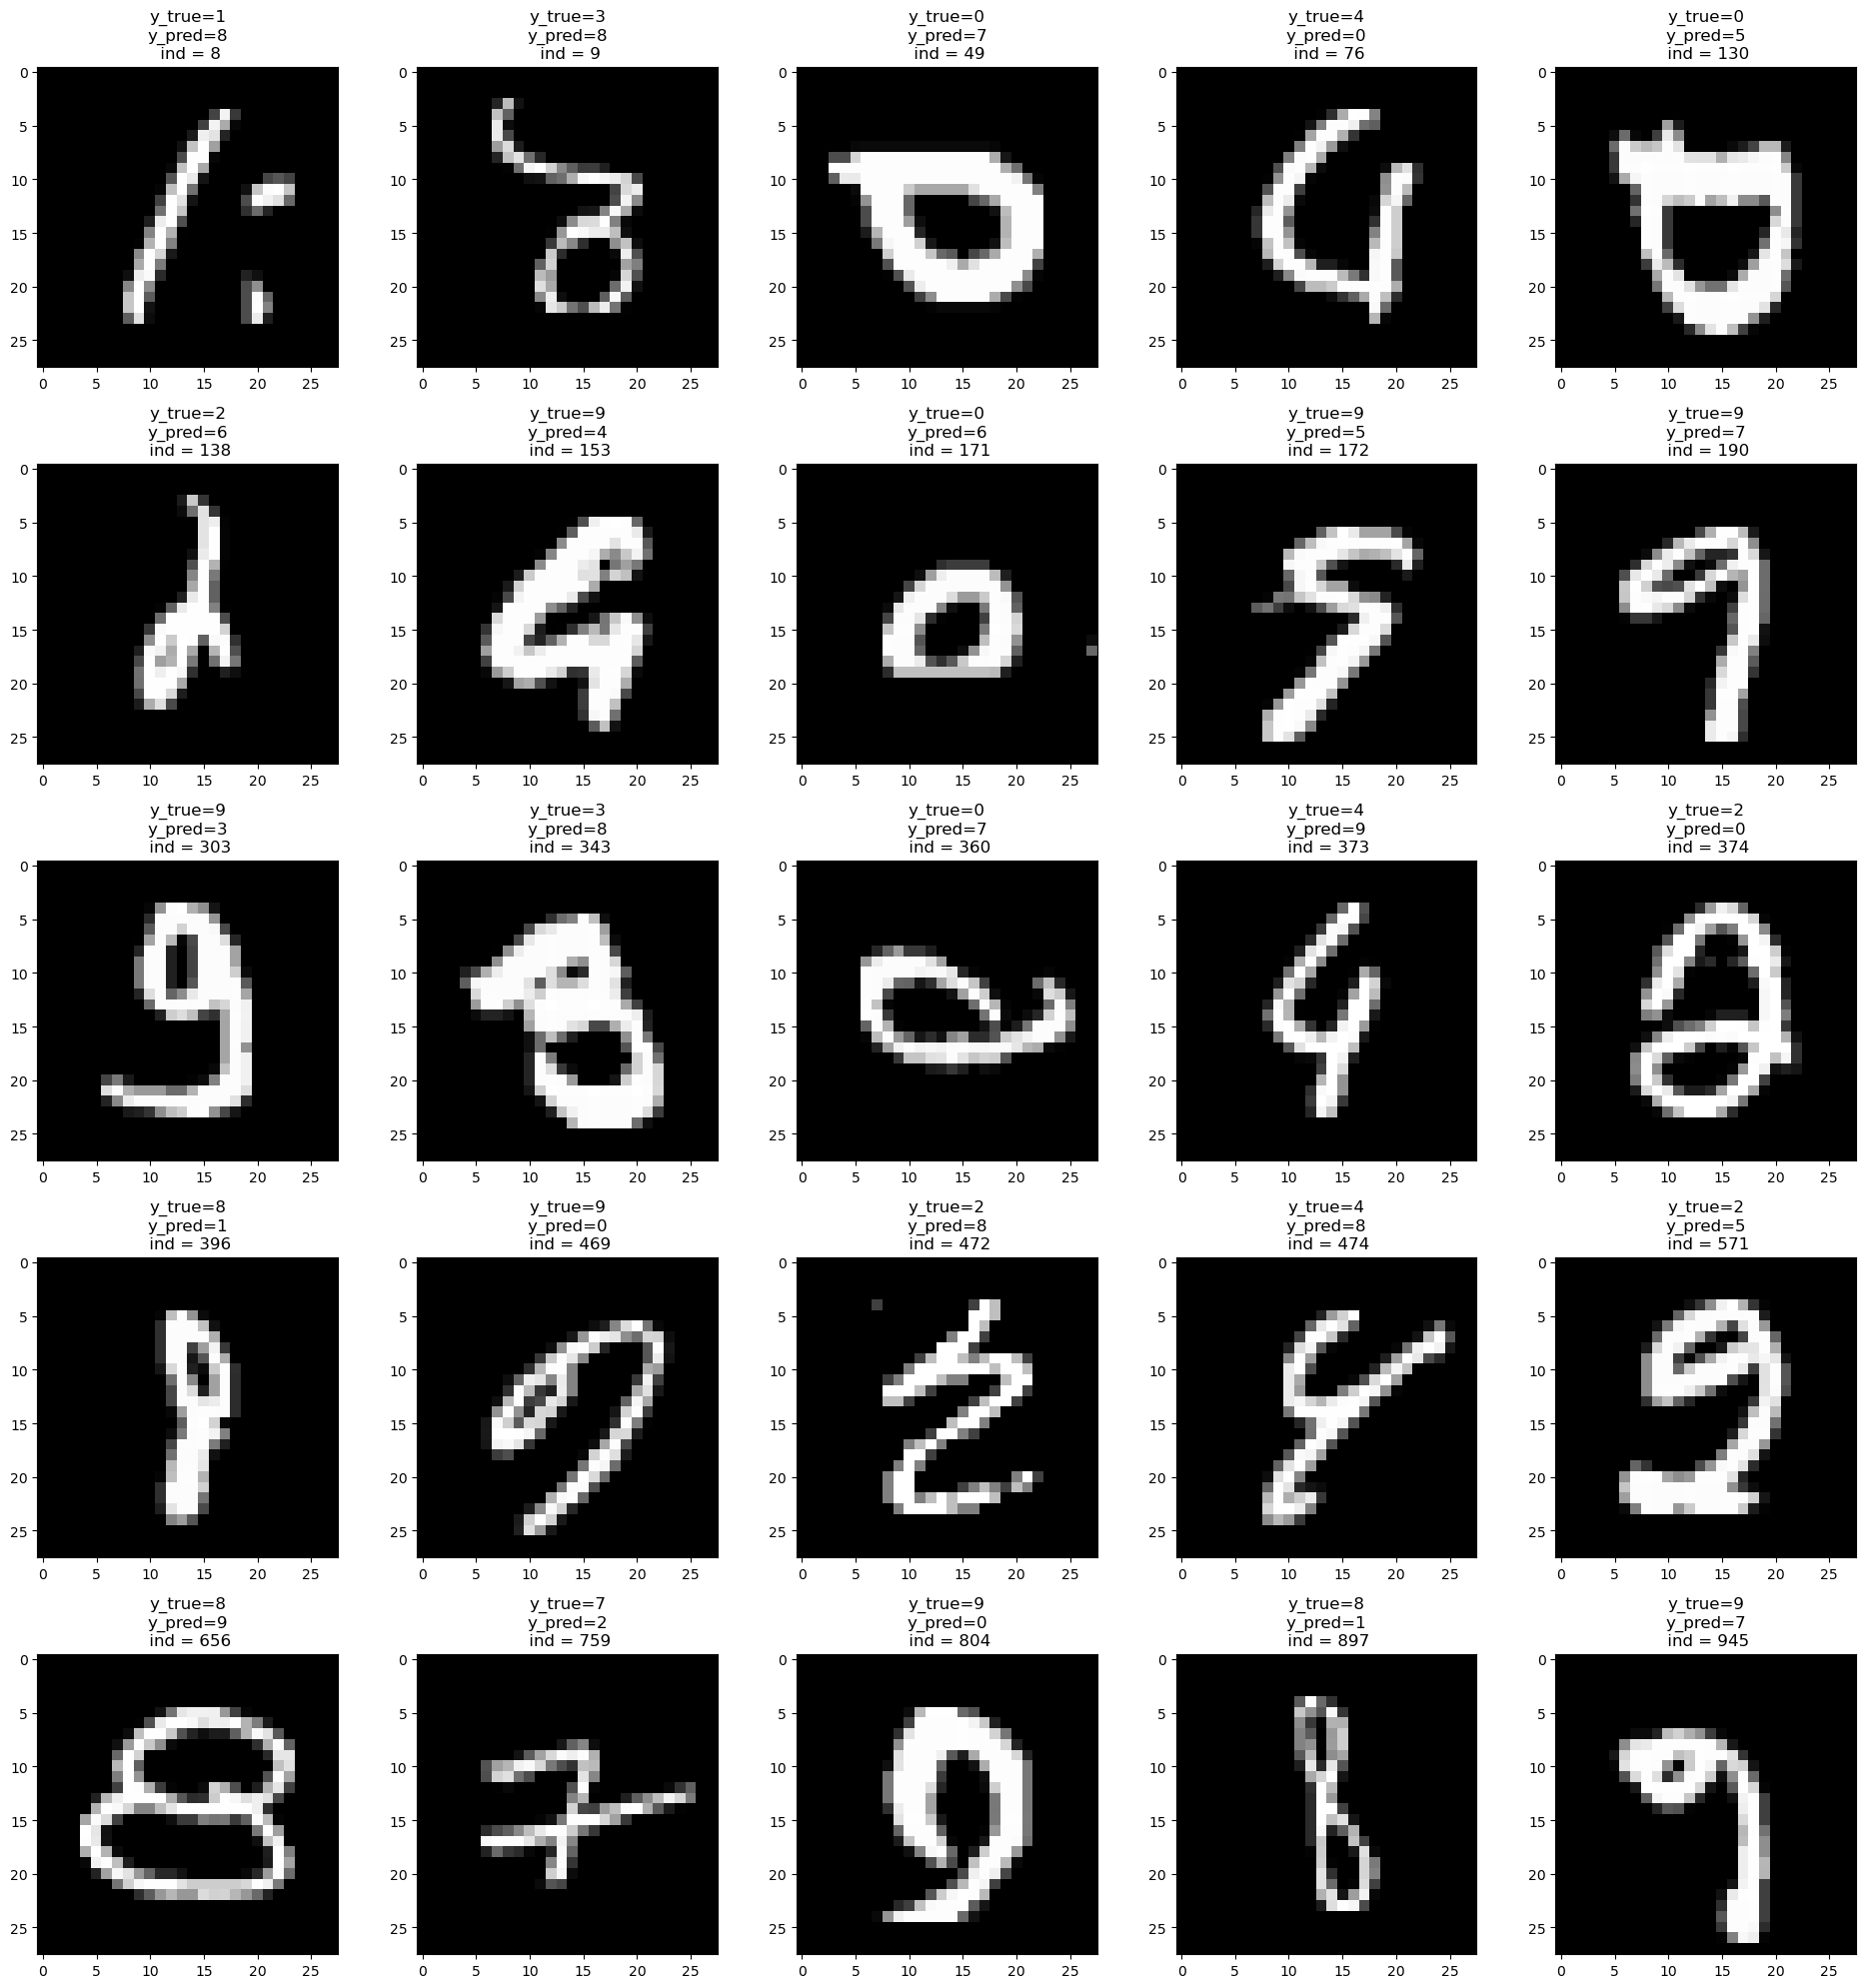

In [243]:
cnt_ind = 1
X_test_plot = X_test.reshape(X_test.shape[:-1])
fig = plt.figure(figsize=(20, 20))

for idx, (a, b) in enumerate(zip(to_categorical(y_test), to_categorical(y_pred_c))):
    #affichage de 25 images pour lesquelles notre modèle s'est trompé
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a)!= np.argmax(b)):
        if cnt_ind > 25: break   
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        cnt_ind += 1

Text(220.72222222222223, 0.5, 'True')

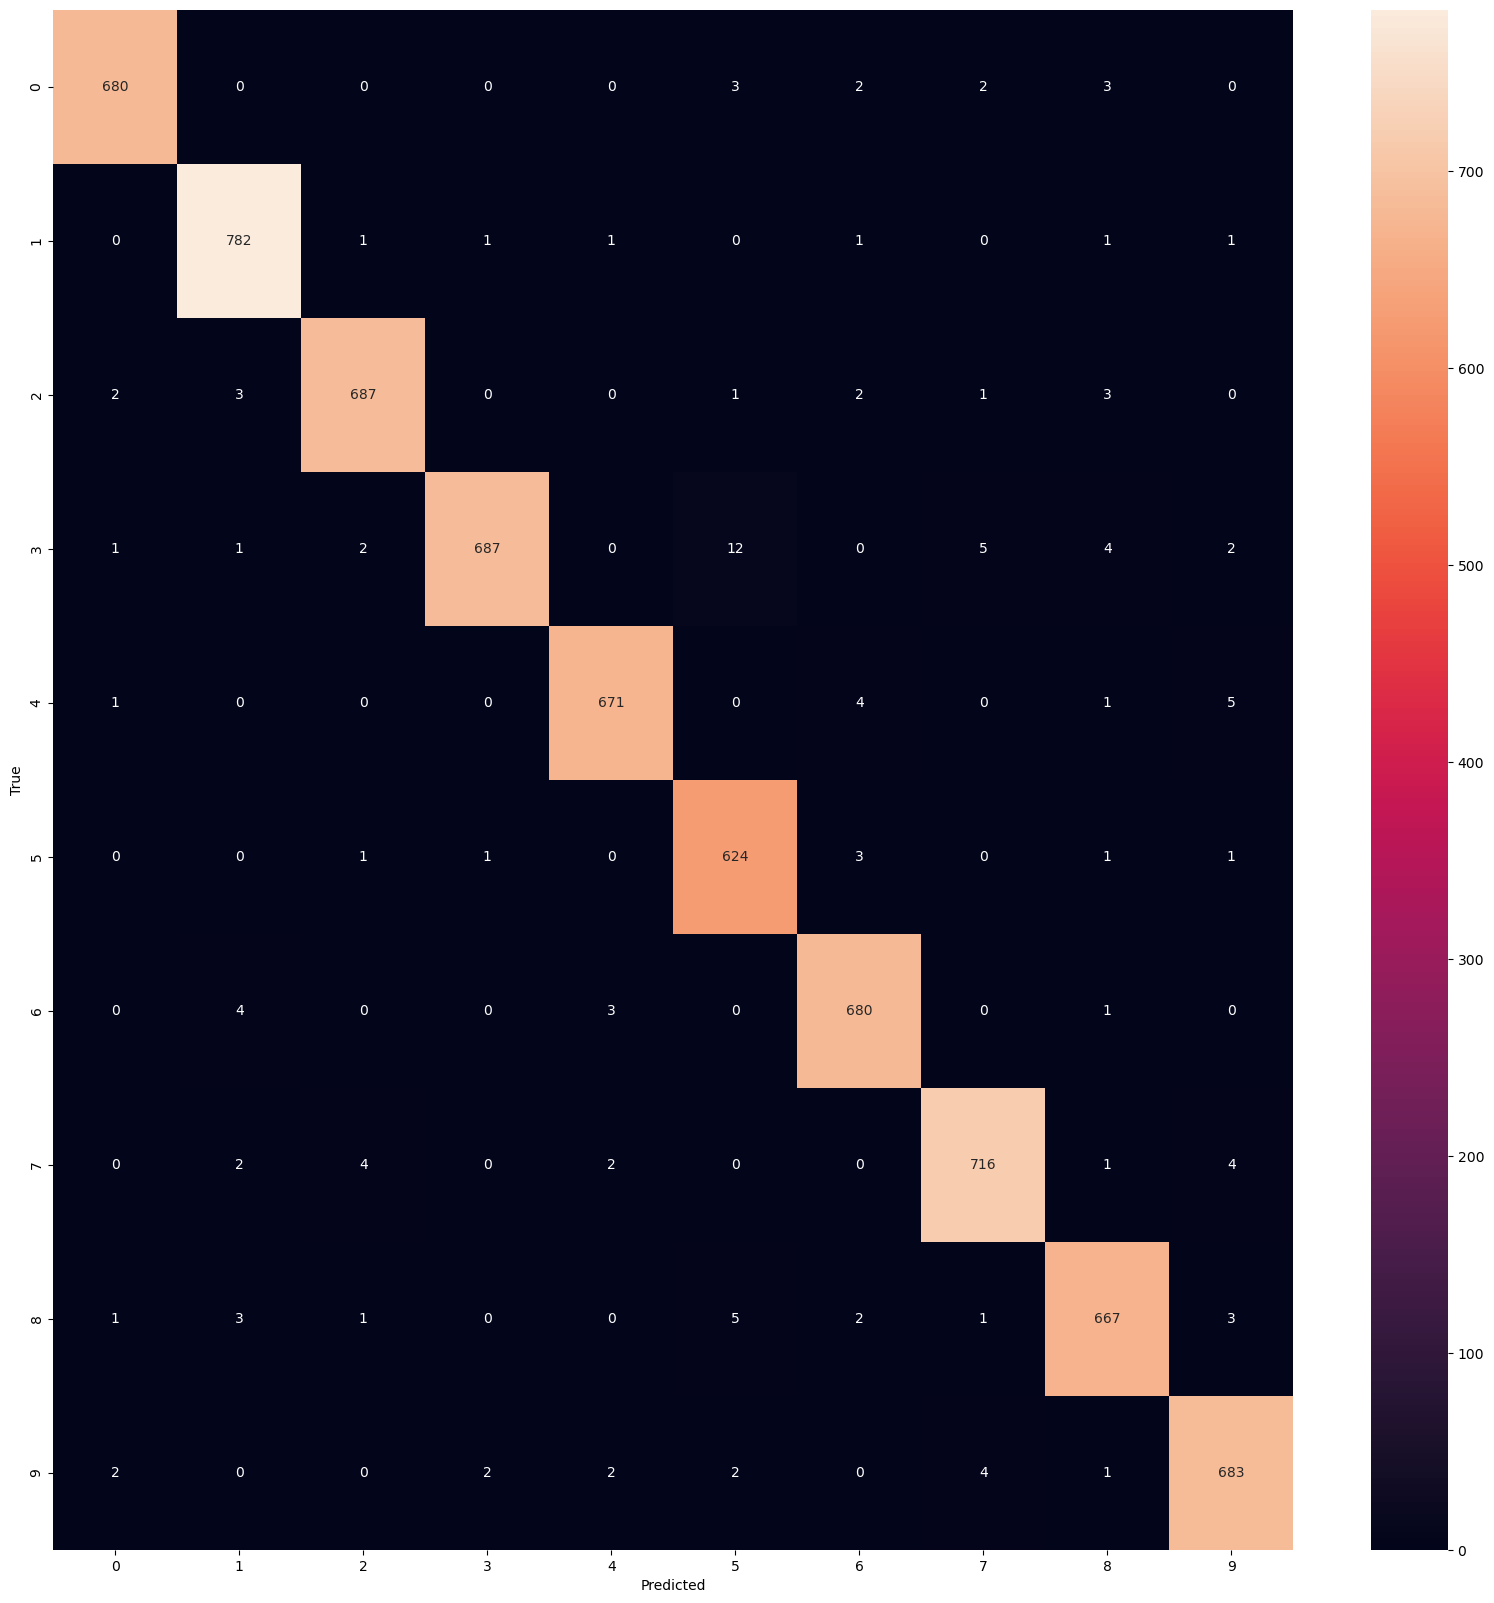

In [246]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_test, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

Nous pouvons mieux visualiser les erreurs comises par notre modèle en utilisant la matrice de confusion, nous avons constaté que le modèle ne predit pas bien surtout le "1" et le "7" qui leurs confond avec les autres chiffres. Cela peut être dû au nombre de composantes choisi lors de la SVD pour la réduction des images en passant de 784 à 100 composantes ce qui entraine une perte d'information. De plus, la mauvaise qualité des images fournie (Mnist)  qui affecte sur la détection des chiffres manuscrites.